# Standard Kalman Filter Demo

This notebook demonstrates a basic Kalman filter implementation using pykal. The standard Kalman filter implementation is under the `pykal.utilities.estimators.kf` module.

The Kalman filter is an optimal state estimator for linear Gaussian systems. It recursively estimates the state of a dynamic system from noisy measurements by performing a predict-update cycle at each time step.

## Import pykal

Import the necessary modules from pykal for creating dynamical systems and using the Kalman filter.

In [1]:
from pykal import DynamicalSystem
from pykal.utilities.estimators.kf import KF
import numpy as np
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Define Dynamical System

### Evolution Function 

The evolution function performs the complete **Predict-Update cycle** and returns the updated state estimate and covariance.

In [2]:
from typing import Tuple,Callable,Dict
from numpy.typing import NDArray

def kf_f(
    *,            
    xhat_P: Tuple[NDArray, NDArray],  
    yk: NDArray,
    f: Callable,
    f_params: Dict,
    h: Callable,
    h_params: Dict,                        
    Fk: NDArray,
    Qk: NDArray,
    Hk: NDArray,
    Rk: NDArray
) -> Tuple[NDArray, NDArray]:
    """
    Perform one full **predict–update** step of the discrete-time Kalman Filter.

    Parameters
    ----------
    xhat_P : Tuple[NDArray, NDArray]
        A tuple ``(x_hat_k, P_k)`` containing:
            - ``x_hat_k`` : the current estimated state of the plant, shape (n,1)
            - ``P_k``     : the current state covariance, shape (n,n)

    yk : NDArray
        The measurement at time k, shape (m,1).

    f : Callable
        The plant evolution function used to propagate the estimated mean:
            ``x_pred = f(**f_params)``
        This should return the **noise-free** predicted state.

    f_params : Dict
        Dictionary of parameters passed to the evolution function ``f``.

    h : Callable
        The plant output function used to compute the predicted measurement:
            ``y_pred = h(**h_params)``
        This should return the **noise-free** predicted measurement.

    h_params : Dict
        Dictionary of parameters passed to the measurement function ``h``.

    Fk : NDArray
        The state-transition Jacobian evaluated at the current estimate,
        used to propagate the covariance. Shape (n,n).

    Qk : NDArray
        The process-noise covariance matrix at time k, shape (n,n).

    Hk : NDArray
        The measurement Jacobian evaluated at the current estimate,
        used in the update. Shape (m,n).

    Rk : NDArray
        The measurement-noise covariance matrix at time k, shape (m,m).


    Returns
    -------
    (x_upd, P_upd) : Tuple[NDArray, NDArray]
        The updated state estimate and covariance:
            - ``x_upd`` : updated state estimate, shape (n,1)
            - ``P_upd`` : updated state covariance, shape (n,n)


    Notes
    -----
    This implementation follows the standard **linearized EKF equations**:

    **Predict step**
    ----------------
    State prediction:
        ``x_pred = f(**f_params)``

    Covariance prediction:
        ``P_pred = Fk @ Pk @ Fk.T + Qk``

    **Update step**
    ---------------
    Innovation:
        ``innovation = yk - y_pred``  
        where ``y_pred = h(**h_params)``

    Innovation covariance:
        ``Sk = Hk @ P_pred @ Hk.T + Rk``

    Kalman gain:
        ``Kk = P_pred @ Hk.T @ Sk^{-1}``

    State update:
        ``x_upd = x_pred + Kk @ innovation``

    Covariance update (Joseph form for numerical stability):
        ``P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T``

    The covariance matrix is explicitly symmetrized at the end to counter
    numerical drift:
        ``P_upd = 0.5 * (P_upd + P_upd.T)``
    """

    # === Extract covariance ===
    _, Pk = xhat_P

    # === Predict ===
    x_pred = f(**f_params)
    P_pred = Fk @ Pk @ Fk.T + Qk

    # === Innovation ===
    y_pred = h(**h_params)
    innovation = yk - y_pred

    # === Update ===
    Sk = Hk @ P_pred @ Hk.T + Rk
    ridge = 1e-9 * np.eye(Sk.shape[0])
    try:
        Sk_inv = np.linalg.inv(Sk + ridge)
    except np.linalg.LinAlgError:
        Sk_inv = np.linalg.pinv(Sk + ridge)

    Kk = P_pred @ Hk.T @ Sk_inv
    x_upd = x_pred + Kk @ innovation

    I = np.eye(P_pred.shape[0])
    P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T
    P_upd = 0.5 * (P_upd + P_upd.T)

    return (x_upd, P_upd)


### Output Function (KF.h)

The output function extracts the state estimate from the tuple `(x̂, P)`

In [3]:
def kf_h(xhat_P: Tuple[NDArray, NDArray]) -> NDArray:
    return xhat_P[0] # extracts current state estimate

## Example: 1D Constant Velocity Tracking
We track a target moving in **1D with (approximately) constant velocity**, where we only observe its **position**. We also include process and measurement noise. We consider the 1D constant-velocity model with state

$$
x_k = \begin{bmatrix} p_k \\ v_k \end{bmatrix},
$$

where $p_k$ is position and $v_k$ is velocity at discrete time $k$.

The discrete-time dynamics with sampling interval $\Delta t$ are:

$$
x_{k+1} =
\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
x_k + w_k,
$$

where $w_k \sim \mathcal N(0, Q)$ is process noise (acceleration noise).

The measurement model observes **position only**:

$$
y_k =
\begin{bmatrix}
1 & 0
\end{bmatrix}
x_k + r_k,
$$

where $r_k \sim \mathcal N(0, R)$ is measurement noise. If we model unknown accelerations as white noise, a standard discrete-time covariance is:

$$
Q = \sigma_a^2
\begin{bmatrix}
\frac{\Delta t^4}{4} & \frac{\Delta t^3}{2} \\
\frac{\Delta t^3}{2} & \Delta t^2
\end{bmatrix},
$$

and the measurement covariance is:

$$
R = \sigma_y^2.
$$

In this example we choose:

- acceleration noise: $\sigma_a = 0.5$  
- measurement noise: $\sigma_y = 1.0$

In [4]:
from numpy.random import default_rng
rng = default_rng(seed=0)   # optional seed

def target_f(xk,Ak,Qk):
    w_k = rng.multivariate_normal(mean=np.zeros(Qk.shape[0]), cov=Qk).reshape(-1, 1)
    xk_next = Ak @ xk + w_k
    return xk_next

def target_h(xk,Ck,Rk):
    r_k = rng.multivariate_normal(mean=np.zeros(Rk.shape[0]), cov=Rk).reshape(-1, 1)
    yk = Ck @ xk + r_k
    return yk

target = DynamicalSystem(f=target_f,h=target_h,state_name="pos_vel")

In [5]:
kf = DynamicalSystem(f=kf_f,h=kf_h,state_name="xest_P") # define the kf

<Axes: >

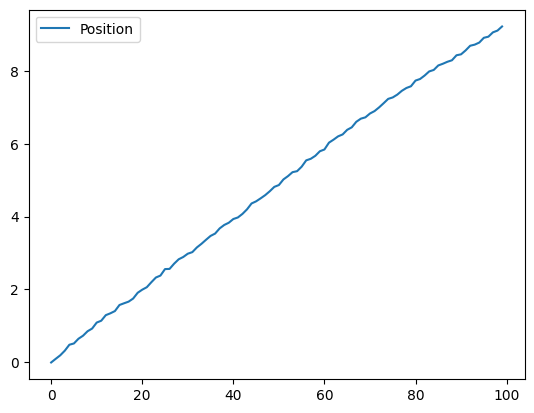

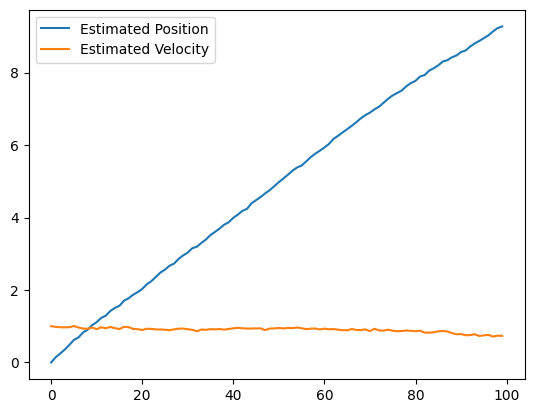

In [6]:
import numpy as np
import pandas as pd

# Define covariances
Qk = np.array([[1e-4, 0],
               [0,    1e-4]])
Rk = np.array([[1e-3]])
Pk = np.array([[1e-3, 0],
               [0,    1e-3]])

# Initial state (column vector)
xk = np.array([[0.0],
               [1.0]])
xk_kf = [xk,Pk]
measurements = []
kf_state_estimates = []

dt = 0.1
for tk in np.arange(0, 10, dt):

    Ak = np.array([[1, dt],
                   [0, 1]])

    Ck = np.array([[1, 0]])

    xk,yk = target.step(
        return_state=True,
        param_dict={
            "xk": xk,
            "Ak": Ak,
            "Ck": Ck,
            "Qk": Qk,
            "Rk": Rk
        }
    )

    xk_kf, yk_kf = kf.step(
    return_state=True,
    param_dict={
        "xhat_P":          xk_kf,   
        "yk":              yk,  
        "f":               target_f,   
        "f_params":        {"xk":xk,"Ak":Ak,"Qk":Qk},     
        "h":               target_h,   
        "h_params":        {"xk":xk,"Ck":Ck,"Rk":Rk},     
        "Fk":               Ak,  # linear system means Fk and Hk are just Ak and Ck 
        "Hk":               Ck,  
        "Qk":               Qk,   
        "Rk":               Rk,  
    }
    )


    measurements.append(yk)
    kf_state_estimates.append(yk_kf)

meas_df = pd.DataFrame(np.vstack(measurements),columns=["Position"])
meas_df.plot()

kf_state_est_df = pd.DataFrame(np.array(kf_state_estimates).squeeze(),columns=["Estimated Position", "Estimated Velocity"])
kf_state_est_df.plot()

### 